### Perform analysis after tensor decomposition

In [1]:
%%time
!pip install liana cell2cell decoupler omnipath seaborn==0.11

CPU times: user 52.7 ms, sys: 4.26 ms, total: 57 ms
Wall time: 6.17 s


In [2]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import pickle

import liana as li
import cell2cell as c2c
import decoupler as dc # needed for pathway enrichment

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

%matplotlib inline
import os
import torch

from collections import Counter

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/u

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls '/content/drive/MyDrive/Lab_Research'

 bams				  liana_all_D_ND_fetal
 blacklist.bed.gz		  liana_disease_v_non_diseased
'Cardiac multiome project.gdoc'   liana_final
 chrombpnet_model		  MultiVI_all_nuclei
 chrombpnet_tutorial		  MultiVI_test
 ENCODE_MultiVI_analysis	  MultiVI_tutorial
 ENCODE_RNA_analysis		  nohup.out
 ENCSR868FGK_bias_fold_0.h5	  output_auxiliary
 HDAC3_project			  output_negatives.bed
 hg38.chrom.sizes		  Penn_RNA_scvi_integration
 hg38.chrom.subset.sizes	  splits
 hg38.fa			 'William Gao - Professional Development.gdoc'
 hg38.fa.fai


In [6]:
working_dir = "/content/drive/MyDrive/Lab_Research/liana_final/"

# change to the working directory
os.chdir(working_dir)

In [7]:
# load in the tensor from step 1 (performed on methylome3 server)
with open("disease_binary_cardiac_tensor.pkl", 'rb') as file:
    tensor = pickle.load(file)

# load in the tensor metadata
with open("disease_binary_cardiac_tensor_metadata.pkl", 'rb') as file:
    tensor_meta = pickle.load(file)

# load in the decomposed tensor after the step 2 script
with open("post_factorization_cardiac_tensor.pkl", 'rb') as file:
    tensor2 = pickle.load(file)

In [8]:
# NOTE: to use CPU instead of GPU, set use_gpu = False
use_gpu = True

if use_gpu:
    import torch
    import tensorly as tl

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        tl.set_backend('pytorch')
else:
    device = "cpu"

device

'cuda'

### Produce initial plots

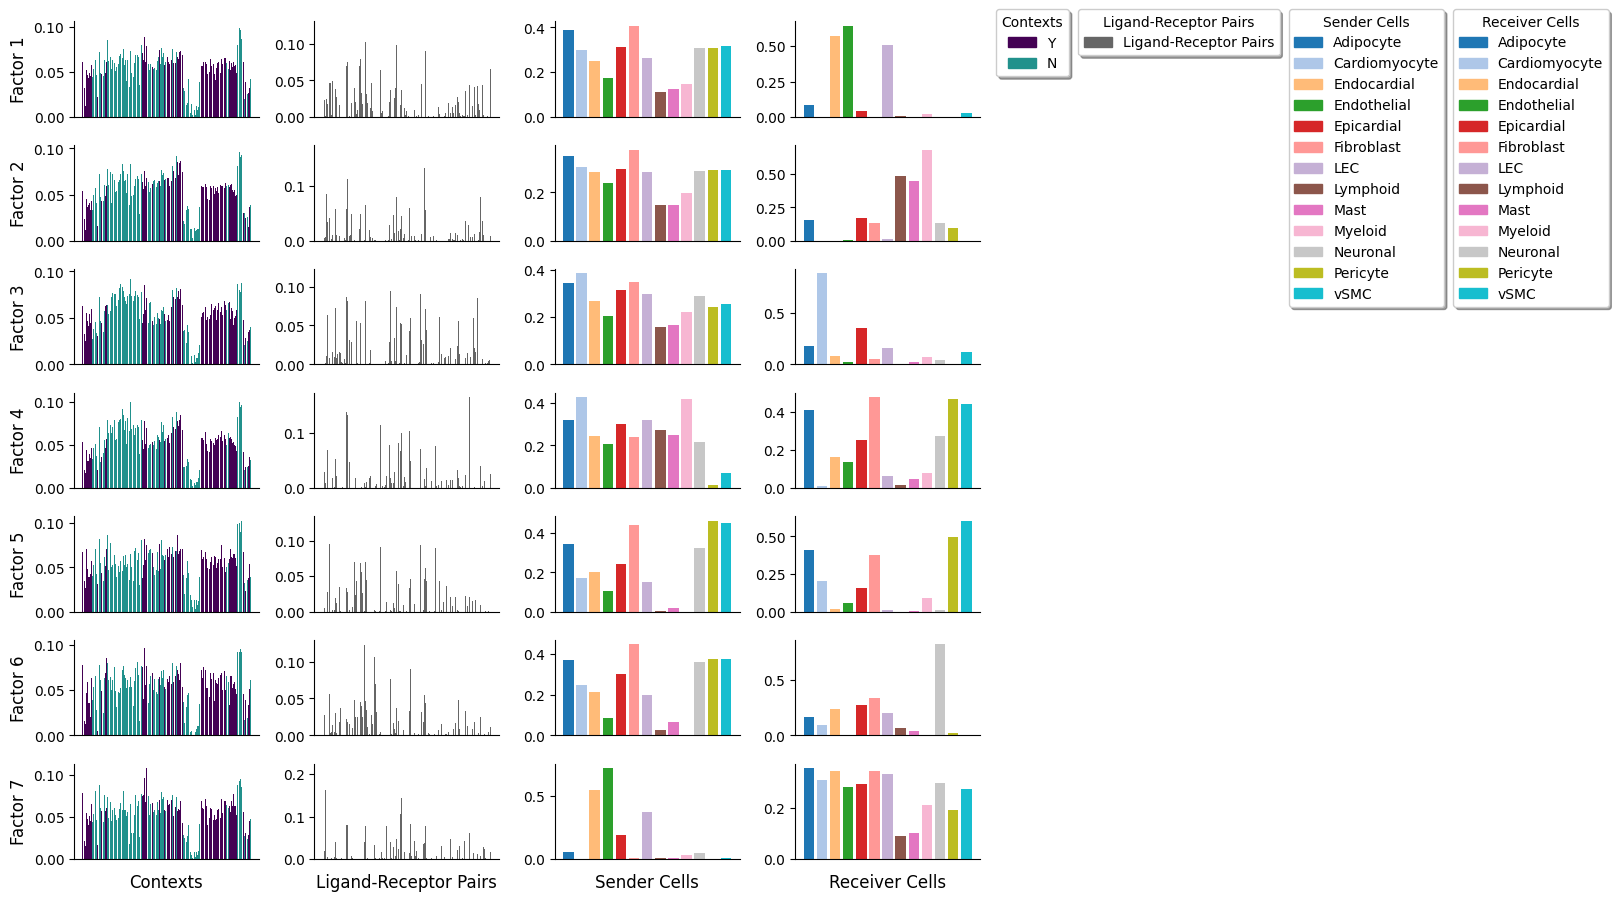

In [9]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor2,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )

In [10]:
sample_key = 'donor_id'
groupby = 'final_cell_type'

In [11]:
# load in the metadata
adata_metadata = pd.read_csv('01_adata_metadata.csv', index_col = 0)

#### Combine the age_status and disease status together, and use this as the contrast for the analysis

In [12]:
# add another column for disease_binary_and_age_status
adata_metadata['disease_binary_and_age_status'] = adata_metadata['age_status'].astype(str) + "_" + adata_metadata['disease_binary'].astype(str)

In [13]:
Counter(adata_metadata['disease_binary_and_age_status'])

Counter({'fetal_N': 70947, 'postnatal_Y': 1093645, 'postnatal_N': 1141372})

In [14]:
# make this the condition to compare on
condition_key = 'disease_binary_and_age_status'

In [15]:
context_dict = adata_metadata[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

### Generate boxplots based on contrast



In [16]:
factors = tensor2.factors
factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

In [17]:
custom_colors = {
    "ND": "#7CAE00",       # green
    "fetal": "#F8766D",    # red
    "disease": "#C77CFF"   # purple
}

# Create a colormap object
custom_cmap = sns.color_palette([custom_colors["ND"], custom_colors["fetal"], custom_colors["disease"]])

In [18]:
def create_contrast_boxplot(adata_metadata, condition_key, condition_orders):
  # create a context dictionary
  context_dict = adata_metadata[[sample_key, condition_key]].drop_duplicates()

  context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
  context_dict = defaultdict(lambda: 'Unknown', context_dict)

  tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

  boxplot = c2c.plotting.context_boxplot(context_loadings=factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=2,
                                 figsize=(10, 10),
                                 group_order=groups_order,
                                 statistical_test='t-test_ind',
                                 pval_correction='fdr_bh',
                                 cmap=custom_cmap,
                                 verbose=False,
                                )

  return(boxplot)

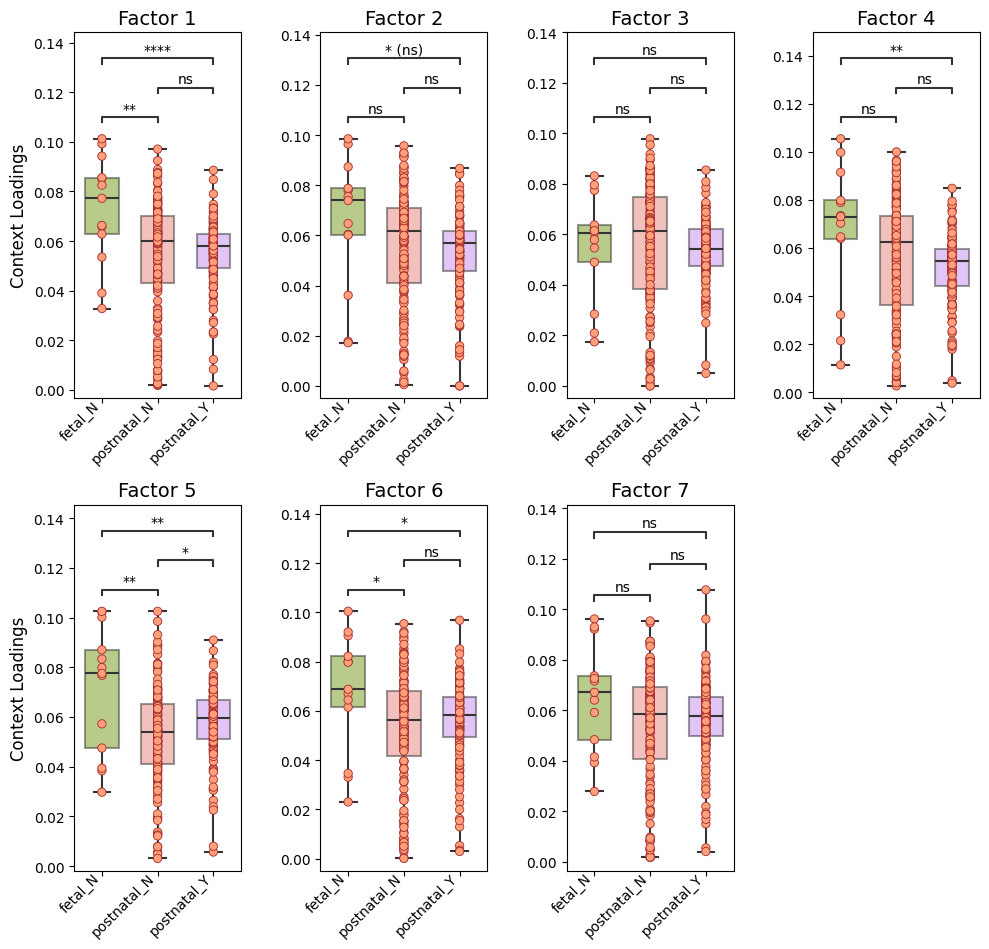

In [19]:
condition_key = 'disease_binary_and_age_status'
groups_order = ['fetal_N', 'postnatal_N', 'postnatal_Y']
create_contrast_boxplot(adata_metadata = adata_metadata, condition_key = condition_key,
                        condition_orders = groups_order, )

plt.savefig("Factor_loadings_box_plot.pdf")

In [20]:
factors = tensor2.factors
factors.keys()
factor_names = factors['Contexts'].columns.tolist()
factor_names

['Factor 1',
 'Factor 2',
 'Factor 3',
 'Factor 4',
 'Factor 5',
 'Factor 6',
 'Factor 7']

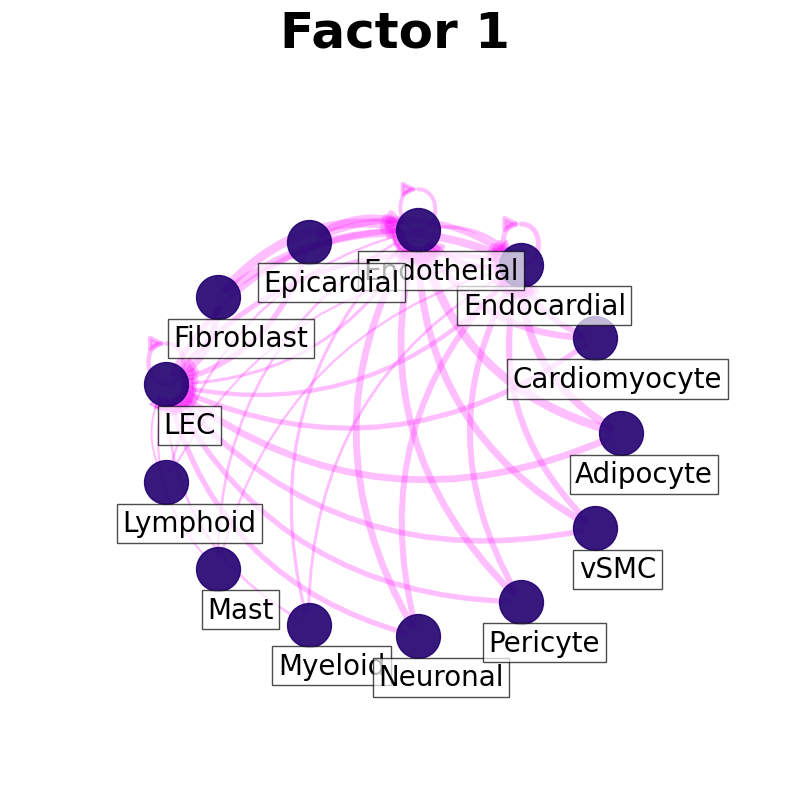

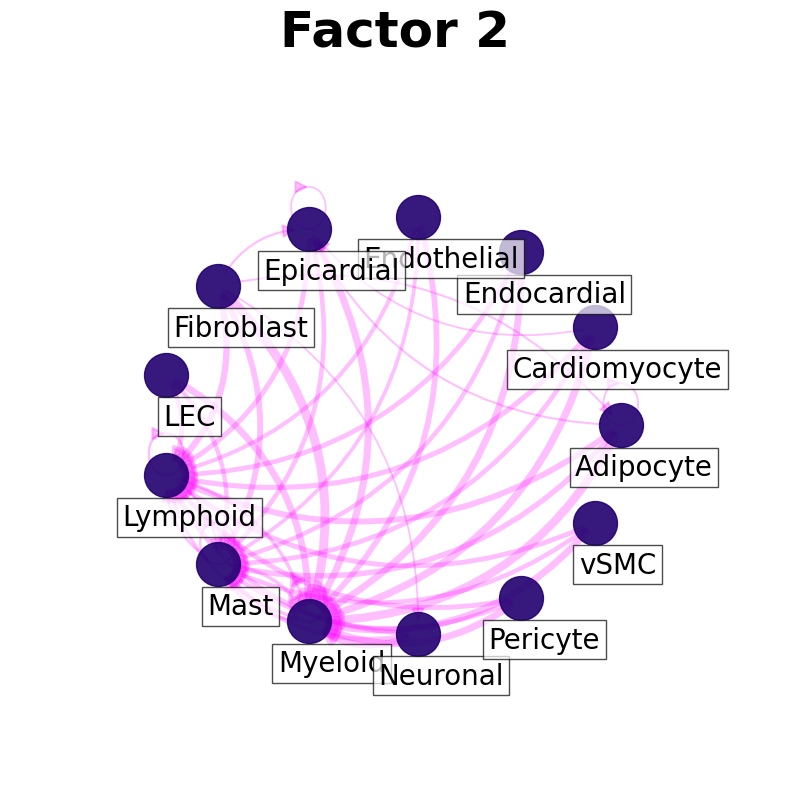

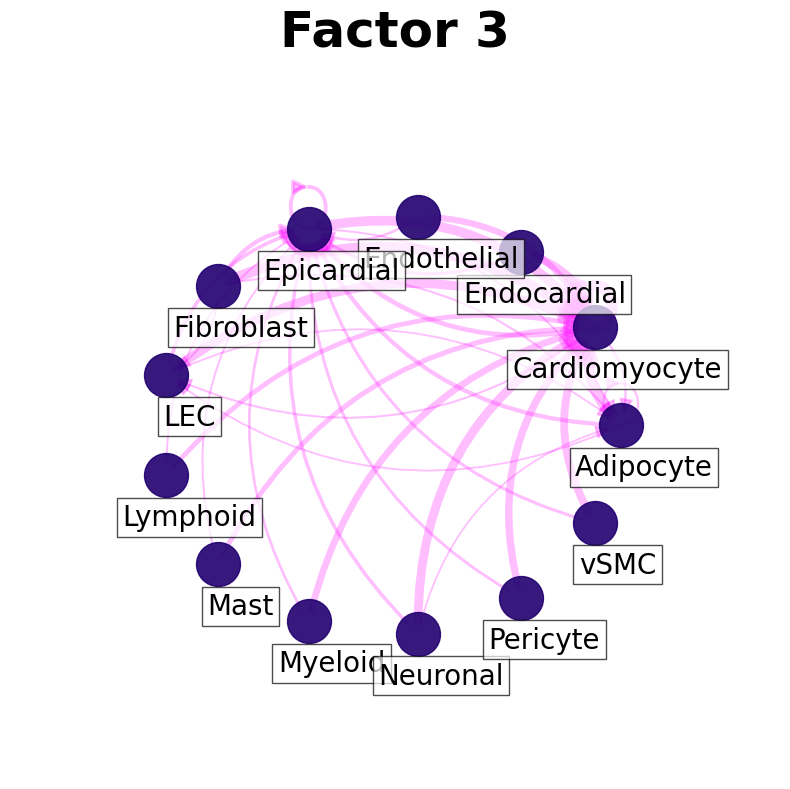

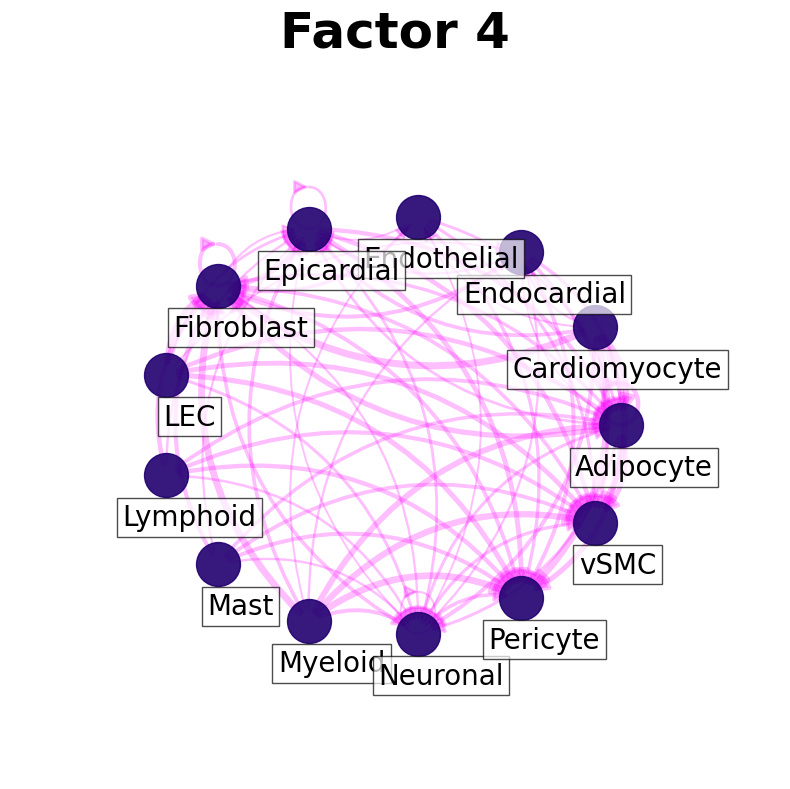

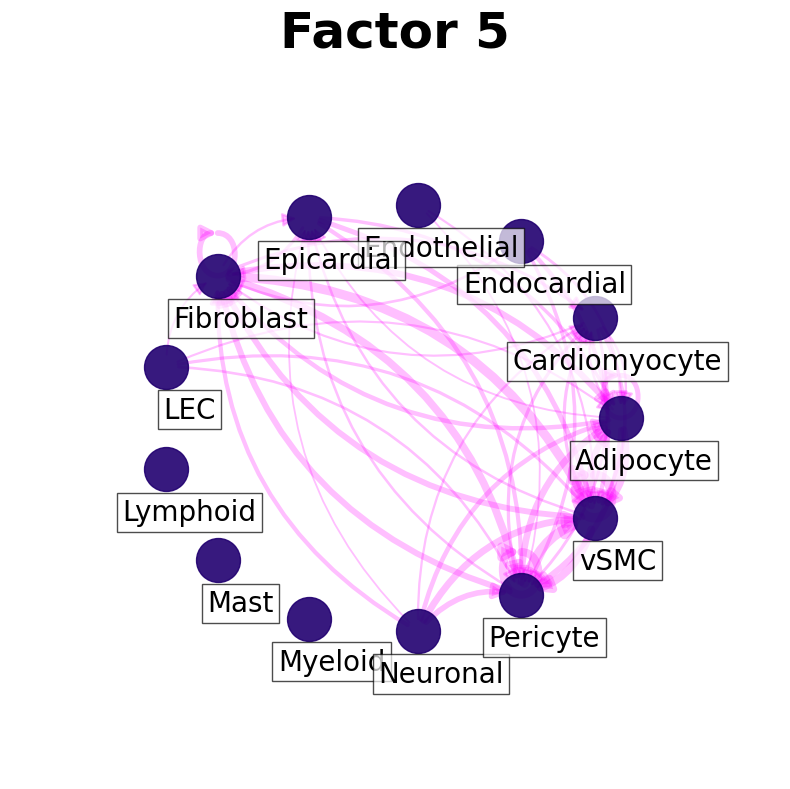

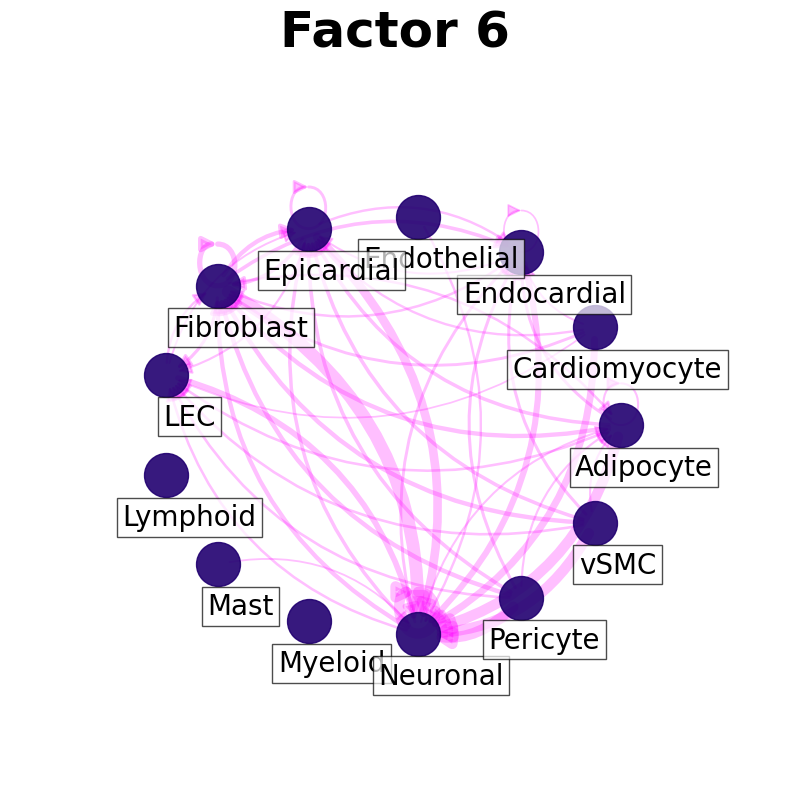

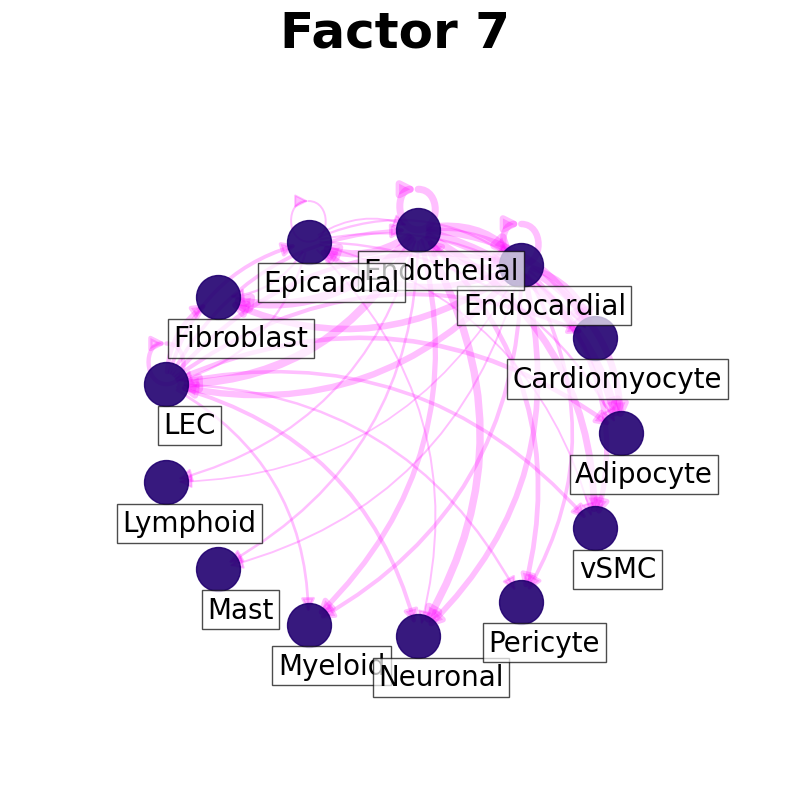

In [21]:
circos_dir = "Circos_plots/"
os.makedirs(circos_dir, exist_ok=True)

factor_names = factors['Contexts'].columns.tolist()

for factor in factor_names:

  c2c.plotting.ccc_networks_plot(factors,
                               included_factors=[factor],
                               network_layout='circular',
                               ccc_threshold=0.05, # Only important communication
                               nrows=1,
                               panel_size=(8, 8), # This changes the size of each figure panel.
                              )

  plt.savefig(circos_dir + factor + "_circos_plot.pdf")

In [22]:
lr_loadings = factors['Ligand-Receptor Pairs']
lr_loadings.sort_values("Factor 1", ascending=False).head(10)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
ADAM10^TSPAN14,0.124392,0.116249,0.009601,0.054321,3.121180e-02,0.000002,0.038831
MAML2^NOTCH1,0.122030,0.015304,0.000481,0.030861,1.141670e-04,0.028944,0.034522
ADAM10^NOTCH1,0.114065,0.013111,0.000455,0.030807,2.047501e-05,0.023834,0.036918
LAMA2^ITGA9_ITGB1,0.107659,0.072480,0.102695,0.061867,3.841844e-02,0.027892,0.020655
ADAM17^NOTCH1,0.107655,0.012582,0.000360,0.025299,2.835642e-05,0.025194,0.029064
FARP2^PLXNA2,0.104137,0.036096,0.054155,0.048769,5.250116e-02,0.004200,0.039653
LAMA2^ITGA6_ITGB1,0.103168,0.034312,0.075676,0.000010,2.838970e-09,0.055581,0.014460
LAMC1^ITGA9_ITGB1,0.102836,0.063550,0.082115,0.003023,6.913531e-02,0.047148,0.073895
COL4A2^ITGA9_ITGB1,0.102699,0.064459,0.081434,0.001714,6.948461e-02,0.046791,0.077965
COL4A1^ITGA9_ITGB1,0.101922,0.063648,0.081134,0.000875,6.957264e-02,0.046644,0.075144


### Perform clustering of factors along the dimensions of the tensor

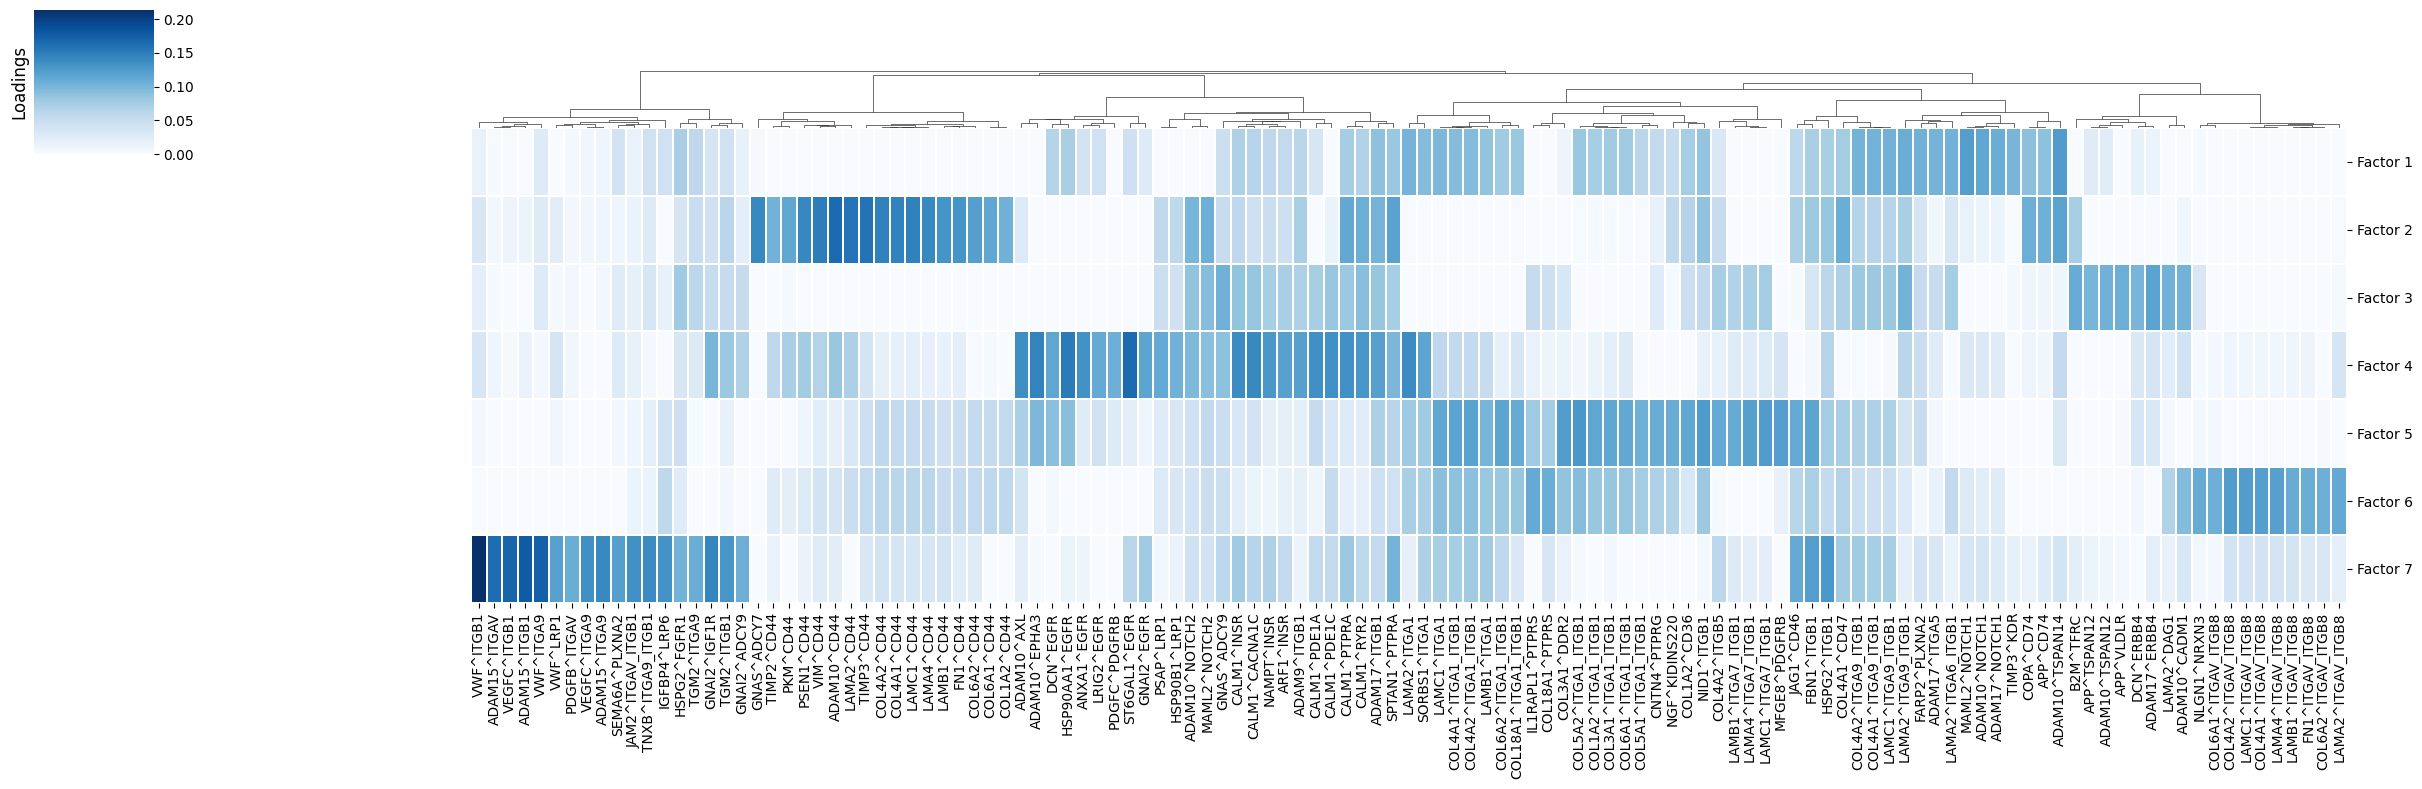

In [23]:
fig_filename = working_dir + "Factor_CCC_in_terms_of_ligand_receptor_interaction.pdf"

c2c.plotting.loading_clustermap(loadings=tensor2.factors['Ligand-Receptor Pairs'],
                                loading_threshold=0.1,
                                use_zscore=False,
                                figsize=(24, 8),
                                filename=fig_filename,
                                row_cluster=False )

In [24]:
tensor2.factors

OrderedDict([('Contexts',
                                   Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  \
              Chaffin 2022:P1290   0.061564  0.053452  0.063170  0.053003  0.067563   
              Chaffin 2022:P1300   0.037712  0.036040  0.051387  0.036947  0.055297   
              Chaffin 2022:P1304   0.038467  0.032150  0.049088  0.039311  0.055529   
              Chaffin 2022:P1358   0.032573  0.023667  0.032522  0.021272  0.034846   
              Chaffin 2022:P1371   0.047402  0.040711  0.053847  0.035555  0.048188   
              ...                       ...       ...       ...       ...       ...   
              Simonson 2023:P1763  0.018766  0.025046  0.032509  0.024103  0.026998   
              Simonson 2023:P1773  0.027166  0.014397  0.034831  0.025539  0.037857   
              Simonson 2023:P1785  0.030823  0.023985  0.019556  0.020980  0.030339   
              Simonson 2023:P1800  0.032412  0.036513  0.036790  0.036439  0.053949   
              Sim

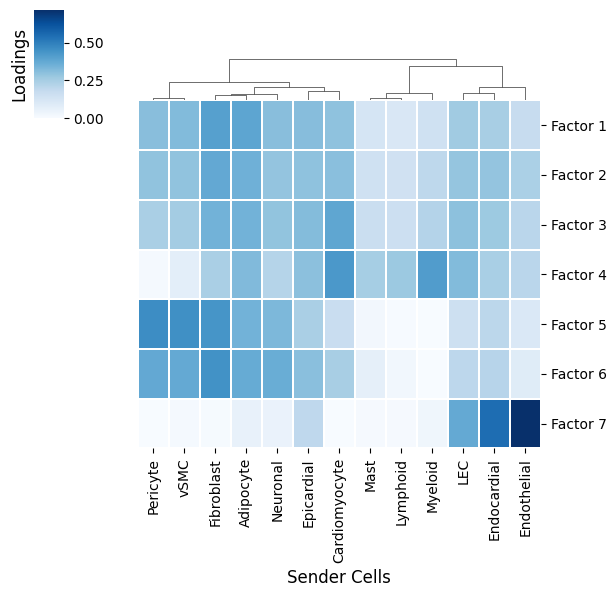

In [25]:
sender_receiver_dir = "loadings_by_sender_and_receiver_cells/"
os.makedirs(sender_receiver_dir, exist_ok=True)

fig_filename= sender_receiver_dir + "Factor_CCC_in_terms_of_sender_cells.pdf"

c2c.plotting.loading_clustermap(loadings=tensor2.factors['Sender Cells'],
                                loading_threshold=0.1,
                                use_zscore=False,
                                figsize=(6, 6),
                                filename=fig_filename,
                                row_cluster=False )

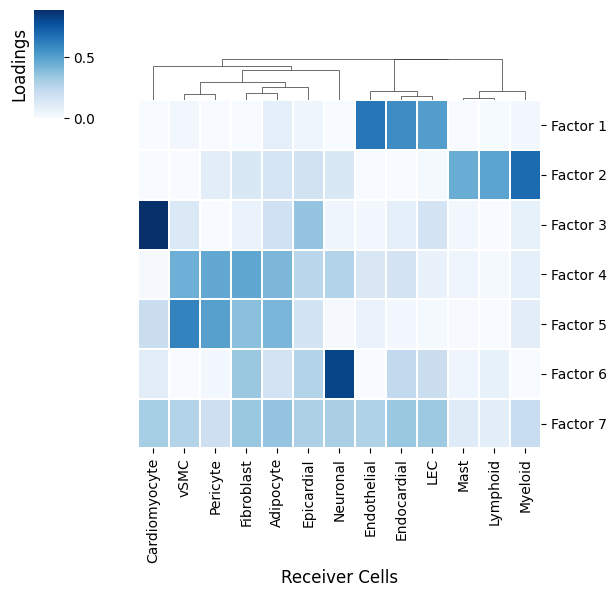

In [26]:
fig_filename= sender_receiver_dir +  "Factor_CCC_in_terms_of_receiver_cells.pdf"
c2c.plotting.loading_clustermap(loadings=tensor2.factors['Receiver Cells'],
                                loading_threshold=0.1,
                                use_zscore=False,
                                figsize=(6, 6),
                                filename=fig_filename,
                                row_cluster=False )

### Downstream Analysis
Let's also perform a basic enrichment analysis on the results above. We will use decoupler with pathway genesets from PROGENy.



In [27]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)

In [28]:
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [29]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

,source,interaction,weight
60,JAK-STAT,LGALS9^PTPRC,1.307807
844,JAK-STAT,LGALS9^CD47,2.054778
1130,Trail,LGALS9^PTPRK,0.937003
1432,JAK-STAT,LGALS9^HAVCR2,1.487678
1779,EGFR,DLL1^NOTCH1,-1.000584


In [30]:
# run enrichment analysis
estimate, pvals = dc.run_ulm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

In [31]:
factor_names

['Factor 1',
 'Factor 2',
 'Factor 3',
 'Factor 4',
 'Factor 5',
 'Factor 6',
 'Factor 7']

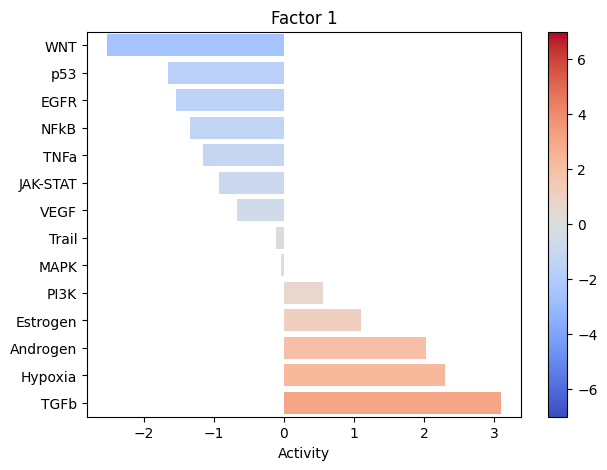

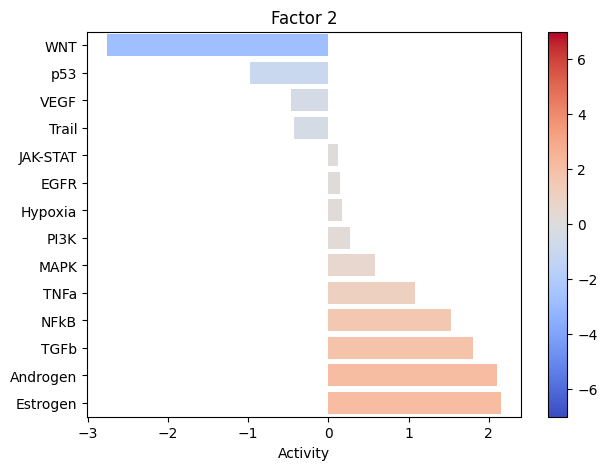

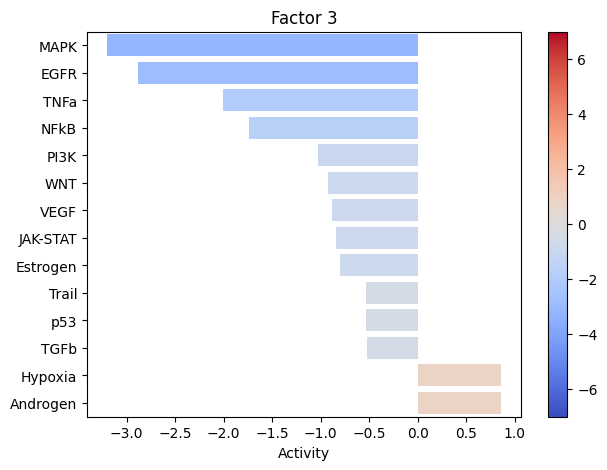

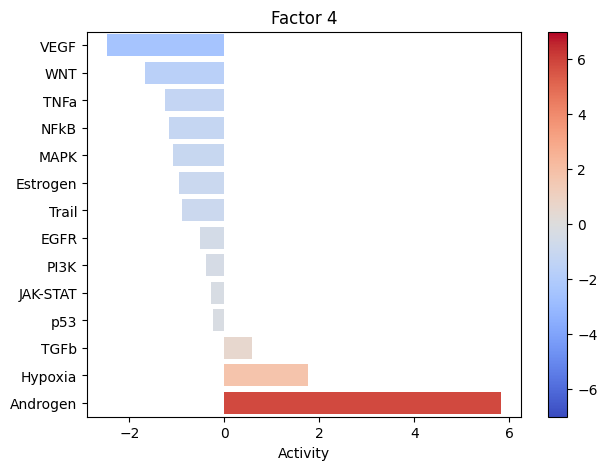

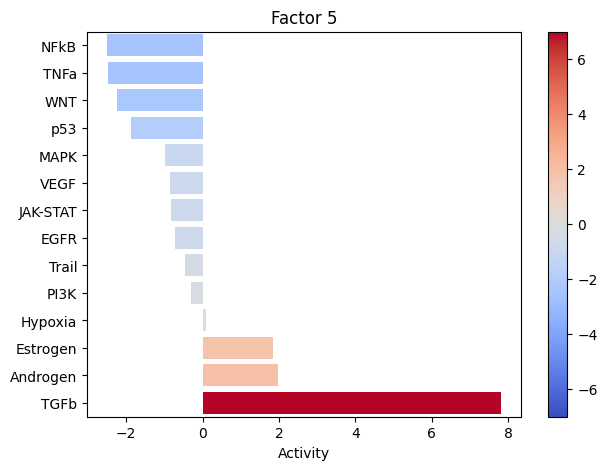

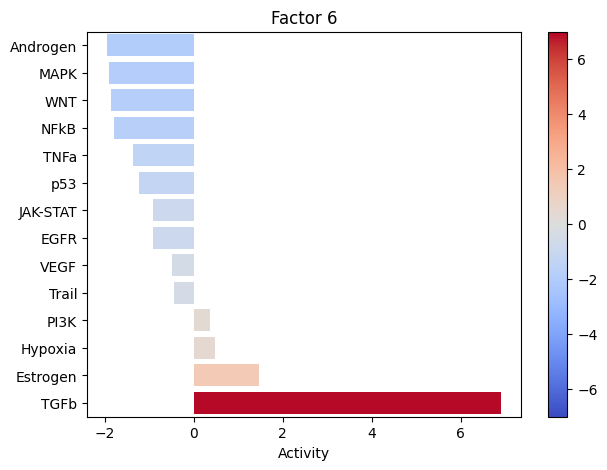

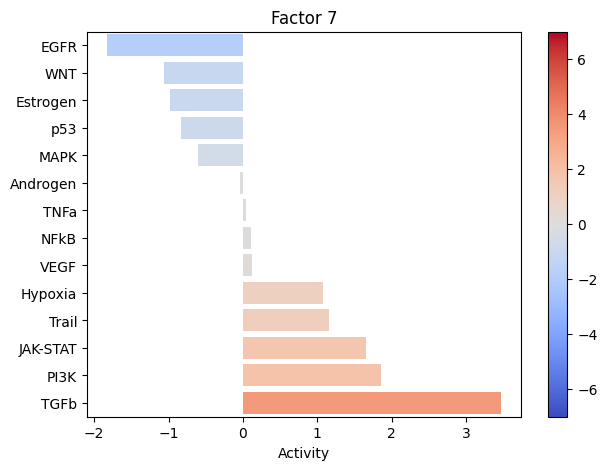

In [32]:
Progeny_dir = "PROGENY_loadings/"
os.makedirs(Progeny_dir, exist_ok=True)

for factor in factor_names:

  dc.plot_barplot(estimate, factor, vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
  plt.title(factor)
  plt.savefig(Progeny_dir + factor + "_Progeny_loadings.pdf")

### Gene set enrichment analysis

In [33]:
lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()]

In [34]:
output_folder = "."

In [35]:
organism = 'human' # For the COVID-19 data analyzed with LIANA+Tensor-cell2cell
pathwaydb = 'KEGG'

In [36]:
lr_set = c2c.external.generate_lr_geneset(lr_list,
                                          complex_sep='_',
                                          lr_sep='^',
                                          organism=organism,
                                          pathwaydb=pathwaydb,
                                          readable_name=True,
                                          output_folder=output_folder
                                          )

In [37]:
pvals, scores, gsea_df = c2c.external.run_gsea(loadings=lr_loadings,
                                               lr_set=lr_set,
                                               output_folder=output_folder,
                                               weight=1,
                                               min_size=15,
                                               permutations=999,
                                               processes=6,
                                               random_state=6,
                                               significance_threshold=0.05,
                                              )

. already exists.


 57%|█████▋    | 4/7 [00:17<00:13,  4.37s/it]2025-01-03 21:17:45,945 [WARNING] Duplicated values found in preranked stats: 0.51% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
100%|██████████| 7/7 [00:26<00:00,  3.84s/it]


In [38]:
pvals

Factor,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7
Term,,,,,,,
AXON GUIDANCE,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.975860
CALCIUM SIGNALING PATHWAY,1.000000,0.606940,0.308067,0.056056,1.000000,1.000000,0.056056
CELL ADHESION MOLECULES CAMS,0.717304,1.000000,0.611839,0.178679,1.000000,0.113940,1.000000
CYTOKINE CYTOKINE RECEPTOR INTERACTION,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
DILATED CARDIOMYOPATHY,0.383113,0.383113,0.009163,0.342330,0.611839,0.571772,1.000000
ECM RECEPTOR INTERACTION,0.009163,0.009163,0.009163,1.000000,0.009163,0.009163,0.009163
ERBB SIGNALING PATHWAY,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FOCAL ADHESION,0.009163,0.383113,0.009163,1.000000,0.009163,0.009163,0.009163
MAPK SIGNALING PATHWAY,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.975860


In [39]:
lr_loadings = factors['Ligand-Receptor Pairs']

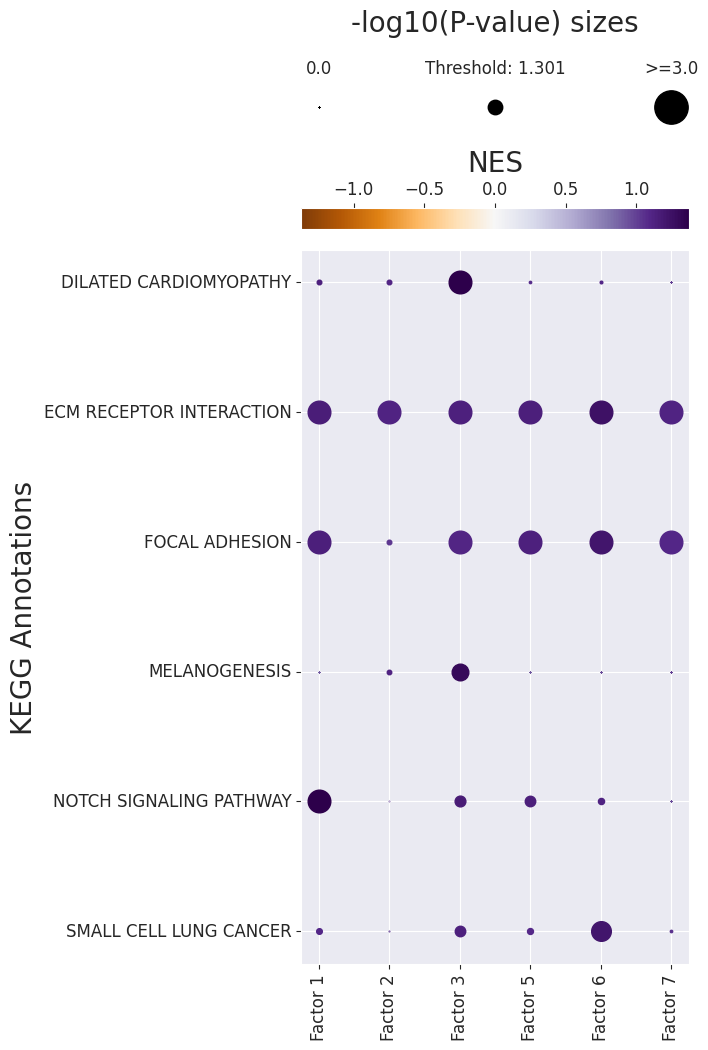

In [40]:
# visualization
with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pvals,
                                                       score_df=scores,
                                                       significance=0.05,
                                                       xlabel='',
                                                       ylabel='{} Annotations'.format(pathwaydb),
                                                       cbar_title='NES',
                                                       cmap='PuOr',
                                                       figsize=(5, 12),
                                                       label_size=20,
                                                       title_size=20,
                                                       tick_size=12,
                                                       filename='GSEA/GSEA-Dotplot.pdf'
                                                      )

In [41]:
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(),
                              lr_progeny,
                              source="source",
                              target="interaction",
                              use_raw=False)

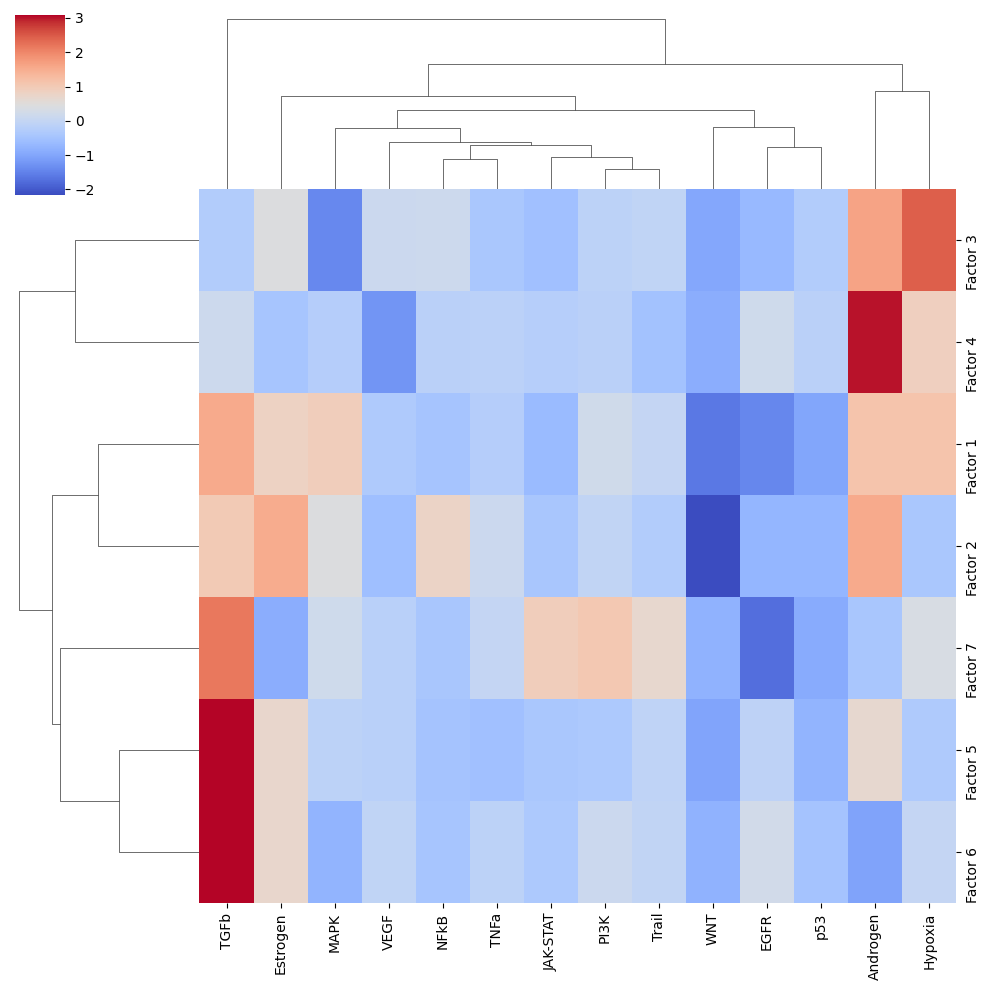

In [42]:
sns.clustermap(estimate, xticklabels=estimate.columns, cmap='coolwarm', z_score=4)
plt.savefig(output_folder + '/PROGENy.pdf', dpi=300, bbox_inches='tight')

### Perform further TGF-beta analysis

In [43]:
pathway = 'TGFb'
selected_factor = 'Factor 5'

# loadings to long format
lr_loadings_long = lr_loadings.reset_index().melt(id_vars='index', var_name="Factor", value_name="Loadings").rename(columns={'index':'interaction'})
# join progeny weights and keep only NFkB pathway
lr_loadings_long = lr_loadings_long.merge(lr_progeny, on='interaction').query("source == '{}' and Factor == '{}'".format(pathway, selected_factor))
# add sign to the weights
lr_loadings_long['sign'] = lr_loadings_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
# keep only relevant interactions for labels
lr_loadings_long['relevant_interactions'] = lr_loadings_long.apply(lambda x: x['interaction'] if (x['Loadings'] > 0.025) and (x['weight'] > 2.5) else None, axis=1)
lr_loadings_long.head()

,interaction,Factor,Loadings,source,weight,sign,relevant_interactions
3258,ADAM10^NOTCH2,Factor 5,0.043266,TGFb,1.250265,positive,None
3260,ADAM10^TSPAN12,Factor 5,0.000001,TGFb,1.039871,positive,None
3264,ADAM12^ITGB1,Factor 5,0.004141,TGFb,2.152959,positive,None
3280,ADAMTS3^CCBE1,Factor 5,0.000017,TGFb,-1.285411,negative,None
3283,ADM^CALCRL,Factor 5,0.000577,TGFb,-3.127671,negative,None


In [44]:
lr_loadings_long[1:50].sort_values(by = "weight", ascending=False)

,interaction,Factor,Loadings,source,weight,sign,relevant_interactions
3424,COL4A1^ITGA11_ITGB1,Factor 5,3.059476e-02,TGFb,4.101322,positive,COL4A1^ITGA11_ITGB1
3439,COL5A1^ITGA11_ITGB1,Factor 5,3.709345e-02,TGFb,3.543103,positive,COL5A1^ITGA11_ITGB1
3425,COL4A1^ITGA1_ITGB1,Factor 5,1.171937e-01,TGFb,3.498864,positive,COL4A1^ITGA1_ITGB1
3426,COL4A2^ITGA11_ITGB1,Factor 5,3.121792e-02,TGFb,3.043209,positive,COL4A2^ITGA11_ITGB1
3440,COL5A1^ITGA1_ITGB1,Factor 5,1.047829e-01,TGFb,2.940645,positive,COL5A1^ITGA1_ITGB1
3410,COL1A1^DDR1,Factor 5,5.108522e-04,TGFb,2.856751,positive,None
3411,COL1A1^ITGA11_ITGB1,Factor 5,2.495724e-02,TGFb,2.715618,positive,None
3415,COL1A1^ITGA5,Factor 5,1.491298e-02,TGFb,2.502455,positive,None
3343,BMP1^BMPR2,Factor 5,7.274628e-02,TGFb,2.496876,positive,None
3427,COL4A2^ITGA1_ITGB1,Factor 5,1.184842e-01,TGFb,2.440751,positive,None


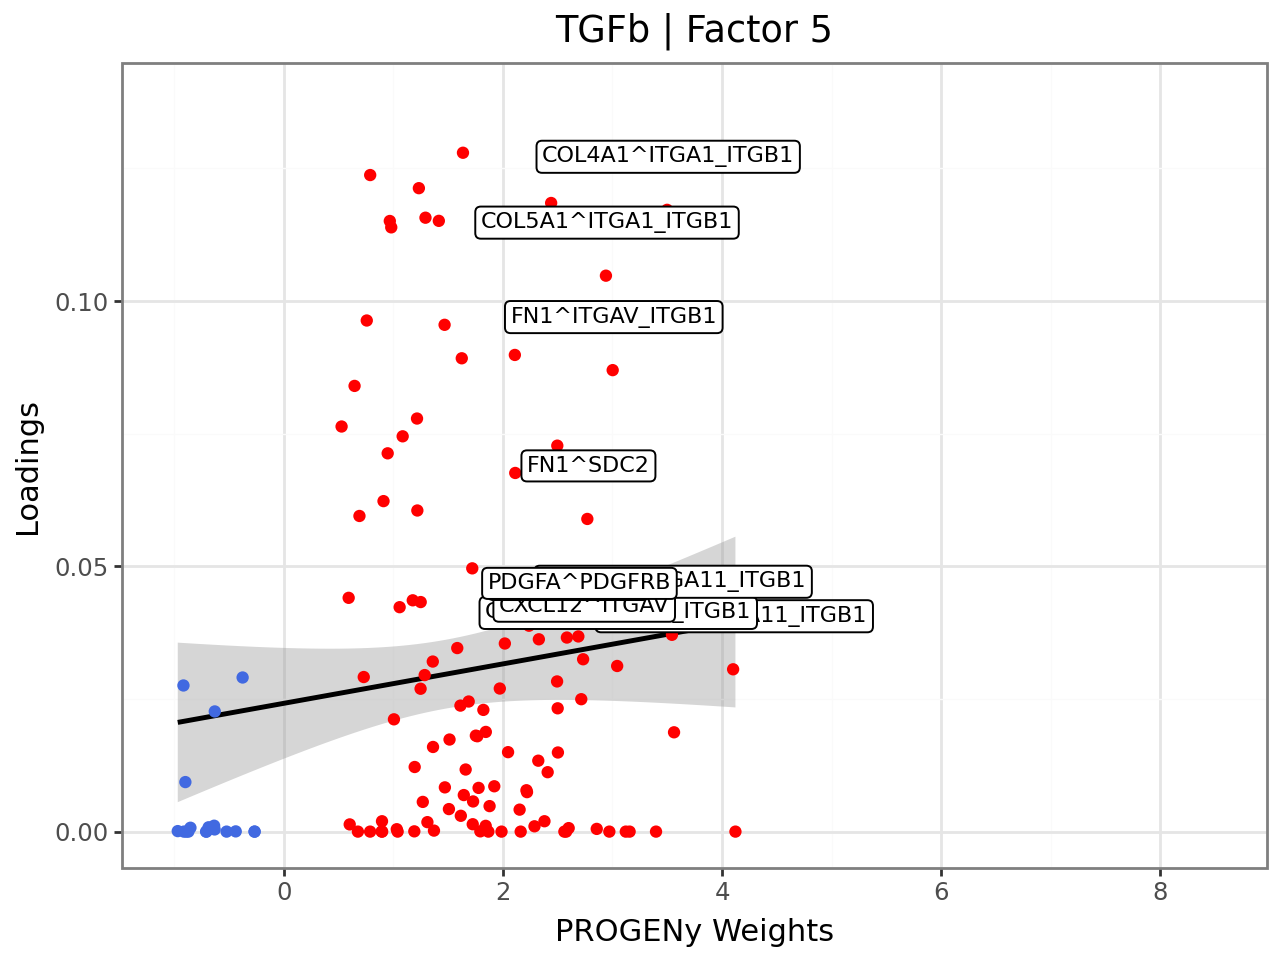

In [45]:
plot = (p9.ggplot(lr_loadings_long,
           p9.aes(x='weight', y='Loadings')) +
 p9.geom_smooth(method='lm') +
 p9.geom_point(p9.aes(colour='sign')) +
 p9.theme_bw() +
 p9.theme(legend_position='none') +
 p9.labs(title="{} | {}".format(pathway, selected_factor), x="PROGENy Weights", y="Loadings") +
 p9.scale_colour_manual(values=["royalblue", "red"]) +
 p9.geom_label(p9.aes(label='relevant_interactions'), size=8, nudge_y=0.01, nudge_x=0.01) +
 p9.xlim(-1, 8.5)
 )

plot.save(filename = output_folder + "/TGFb_Factor_CCC_interaction_weights.pdf", width = 10, height = 6, dpi = 300)

plot

In [46]:
# loadings to long format

def extract_loadings(pathway, select_factor):
  lr_loadings_long = lr_loadings.reset_index().melt(id_vars='index', var_name="Factor", value_name="Loadings").rename(columns={'index':'interaction'})
  # join progeny weights and keep only NFkB pathway
  lr_loadings_long = lr_loadings_long.merge(lr_progeny, on='interaction').query("source == '{}' and Factor == '{}'".format(pathway, selected_factor))
  # add sign to the weights
  lr_loadings_long['sign'] = lr_loadings_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
  # keep only relevant interactions for labels
  lr_loadings_long['relevant_interactions'] = lr_loadings_long.apply(lambda x: x['interaction'] if (x['Loadings'] > 0.025) and (x['weight'] > 2.5) else None, axis=1)

  return (lr_loadings_long)

In [47]:
pathway = 'TGFb'
selected_factor = 'Factor 5'

Factor_5_TGFb_loadings = extract_loadings(pathway, selected_factor)

In [48]:
Factor_5_TGFb_loadings.sort_values(by = "Loadings", ascending = False).to_csv("Factor_5_TGFb_loadings.csv")

In [49]:
Factor_5_TGFb_loadings.head()

,interaction,Factor,Loadings,source,weight,sign,relevant_interactions
3258,ADAM10^NOTCH2,Factor 5,0.043266,TGFb,1.250265,positive,None
3260,ADAM10^TSPAN12,Factor 5,0.000001,TGFb,1.039871,positive,None
3264,ADAM12^ITGB1,Factor 5,0.004141,TGFb,2.152959,positive,None
3280,ADAMTS3^CCBE1,Factor 5,0.000017,TGFb,-1.285411,negative,None
3283,ADM^CALCRL,Factor 5,0.000577,TGFb,-3.127671,negative,None


### Continue to the next script that perform more detailed analysis of TGF-beta